In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.stats import ortho_group

device = torch.device('cpu')
#device = torch.device('cuda')
#torch.cuda.get_device_name(device)
torch.manual_seed(0)

In [8]:
def generate_data(U1, U2, n, snr=0.1):
    r = U1.shape[1]
    d1 = U1.shape[0]
    d2 = U2.shape[0]
    z = np.random.normal(0, 1, size=(r, n))
    xi1 = np.random.normal(0, snr, size=(d1, n))
    xi2 = np.random.normal(0, snr, size=(d2, n))
    data1 = U1 @ z + xi1
    data2 = U2 @ z + xi2
    data1 = torch.tensor(data1.T, dtype=torch.float)
    data2 = torch.tensor(data2.T, dtype=torch.float)
    return data1, data2

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, output_dim, bias=False)
        )
  
    def forward(self, x):
        latent = self.encoder(x)
        #x = self.decoder(latent)
        return latent

class DualEncoders(nn.Module):
    def __init__(self, d1, d2, r, e1=None, e2=None):
        super().__init__()
        self.e1 = Encoder(d1, r) if e1 is None else e1
        self.e2 = Encoder(d2, r) if e2 is None else e2

    def sim(self, x1, x2, tau=1):
        latent1, latent2 = self.e1(x1), self.e2(x2)
        latent1, latent2 = F.normalize(latent1), F.normalize(latent2)
        return latent1 @ latent2.T / tau
        
    def forward(self, x1, x2):
        x1_latent = self.e1(x1)
        x2_latent = self.e2(x2)
        return x1_latent, x2_latent

In [10]:
num_epochs = 100
batch_size = 50
learning_rate = 2e-3
tau = 1
snr = 0.3

In [11]:
def weakly_supervised_learning(n,N,snr,ensure_level):
    sup_test_accuracy = 0
    unsup_test_accuracy = 0
    for i_ensure in range(ensure_level):
        d1 = 40
        d2 = 39
        r = 10
        n_test = 10000
        U1 = ortho_group.rvs(d1)[:,:r]
        U2 = ortho_group.rvs(d2)[:,:r]

        data1, data2 = generate_data(U1, U2, n, snr)
        data1_u, data2_u = generate_data(U1, U2, N, snr)
        data1_test, data2_test = generate_data(U1, U2, n_test, snr)

        num_epochs = 100
        batch_size = 50
        learning_rate = 2e-3
        tau = 1


        MMCL = DualEncoders(d1, d2, r)
        optimizer = torch.optim.AdamW(MMCL.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            for i in range(int(n/batch_size)):
                data1_batch, data2_batch = data1[(i*batch_size):((i+1)*batch_size)], data2[(i*batch_size):((i+1)*batch_size)]
                logits = MMCL.sim(data1_batch, data2_batch, tau=tau)

                ## CLIP loss function
                loss1 = - torch.diag(logits).sum() + torch.log(torch.exp(logits).sum(axis=1)).sum()
                loss2 = - torch.diag(logits).sum() + torch.log(torch.exp(logits).sum(axis=0)).sum()

                loss = (loss1 + loss2) / 2 / batch_size
                loss.backward()
                
                optimizer.step()
                optimizer.zero_grad()
          
            

        similarity = MMCL.sim(data1_test, data2_test, tau=1)
        idx = torch.argmax(similarity, dim=1)
    
        acc = (1 - (torch.arange(len(idx)) != idx).sum() / len(idx))#.to('cpu').detach().numpy()
        sup_test_accuracy += acc/ensure_level

        tau = 1
        num_epochs = 100
        
        for l, epoch in enumerate(range(num_epochs)):
            for j in range(int(N/batch_size)):
                data1_batch, data2_batch = data1_u[(j*batch_size):((j+1)*batch_size)], data2_u[(j*batch_size):((j+1)*batch_size)]
                logits = MMCL.sim(data1_batch, data2_batch, tau=tau)

                ## semi-supervised CLIP
                logits1d = logits.view(batch_size**2)
                _, idx = torch.sort(logits1d, descending=True)
                idx = idx[:batch_size] # assuming that there are `batch_size` number of ground-truth edges

                loss1 = - logits1d[idx].sum() + torch.log(torch.exp(logits).sum(axis=1)).sum()
                loss2 = - logits1d[idx].sum() + torch.log(torch.exp(logits).sum(axis=0)).sum()

                loss = (loss1 + loss2) / 2 / batch_size
                loss.backward()
                
                optimizer.step()
                optimizer.zero_grad()
            

        similarity = MMCL.sim(data1_test, data2_test, tau=1)
        idx = torch.argmax(similarity, dim=1)
    
        acc = (1 - (torch.arange(len(idx)) != idx).sum() / len(idx))#.to('cpu').detach().numpy()
        unsup_test_accuracy += acc/ensure_level
    return sup_test_accuracy,unsup_test_accuracy

In [12]:
ensure_level = 1
Nlist_unsup = [500*x for x in range(1,11)]
sup_list, unsup_list = np.zeros((len(Nlist_unsup))), np.zeros((len(Nlist_unsup)))
for i_unsuplist in range(len(Nlist_unsup)):
    sup_list[i_unsuplist], unsup_list[i_unsuplist] = weakly_supervised_learning(300,Nlist_unsup[i_unsuplist],snr,ensure_level)
    print(f"N : {Nlist_unsup[i_unsuplist]} sup1 : {sup_list[i_unsuplist]}, unsup1 : {unsup_list[i_unsuplist]}")


N : 500 sup1 : 0.3877999782562256, unsup1 : 0.4480000138282776
N : 1000 sup1 : 0.39139997959136963, unsup1 : 0.5206999778747559
N : 1500 sup1 : 0.4221000075340271, unsup1 : 0.5665000081062317
N : 2000 sup1 : 0.43220001459121704, unsup1 : 0.5764999985694885
N : 2500 sup1 : 0.4333000183105469, unsup1 : 0.5924000144004822
N : 3000 sup1 : 0.37790000438690186, unsup1 : 0.5864999890327454
N : 3500 sup1 : 0.37870001792907715, unsup1 : 0.5958000421524048
N : 4000 sup1 : 0.3733999729156494, unsup1 : 0.6008999943733215
N : 4500 sup1 : 0.37540000677108765, unsup1 : 0.5936999917030334
N : 5000 sup1 : 0.4156000018119812, unsup1 : 0.5961999893188477


Text(0, 0.5, 'Test Accuracy')

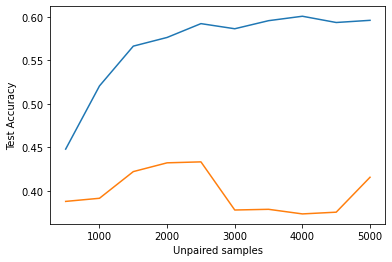

In [13]:
Nlist_unsup = np.array(Nlist_unsup)
np.savez(f"11oct_sup_unsup_n300_d1_40_d2_39_snr_{snr}.npz",sup_list=sup_list,unsup_list=unsup_list,Nlist_unsup=Nlist_unsup)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(Nlist_unsup, unsup_list)
plt.plot(Nlist_unsup, sup_list)
plt.xlabel("Unpaired samples")
plt.ylabel("Test Accuracy")